# Michaud Equations

### The model includes the spatiotemporal dynamics of 
-  Membrane-bound Active Rho (RT)
-  Inactive Rho,
    -  membrane-bound(RD)
    -  cytoplasmic (RDc) pools
- F-actin (F), whose polymerization is

directly stimulated by active Rho.

### The Process

- Inactive Rho on the
membrane reversibly exchanges with its cytoplasmic pool.

- Membrane-bound inactive Rho undergoes both a low-level
background activation and the Ect2-dependent positive-feedback
activation.
- Active Rho induces F-actin polymerization, e.g., via
its effector Dia3 (Fig. 6 G). 
- Freshly polymerized F-actin directly
or via an actin-binding protein recruits Rho GAP RGA-3/4 and
stimulates inactivation of Rho, closing the loop of negative feedback. 
- In the wake of the diminishing Rho activity, the newly
polymerized actin disassembles and recycles back to the cytoplasm.


#### The equations 

$\frac{\partial RT}{\partial t}=R(RT,RD,F | \alpha , \beta)+D_m^{RT}\triangle RT$

$\frac{\partial RD_m}{\partial t}=k_5^* RD_c-k_6RD_m -R(RT,RD,F| \alpha , \beta)+D_{RD}\triangle RD_m$

$\frac{\partial RD_c}{\partial t}= \eta [k_6 RD_m - k_5^* RD_c] + D_c^{RD}\triangle RD_c$

$\frac{\partial F}{\partial t}=k_7+k_8\frac{RT^2}{1+k_9RT^2}-k_{10}dW(\sigma,s)F+D_F\triangle F$

#### The simplification assumptions

- Assume that the entire membrane-bound amount is only a small fraction of the total cellular quantity of the GTPase $RD_c= RD_0$ Thus:
    - Let $k_5 = k_5^* RD_0$
    - Let $D_{RT}= D_m^{RT}$
    - Let $D_{RD} = D_m^{RD}$

#### The simplified equations

- $\frac{\partial RT}{\partial t}=R(RT,RD,F)+D_{RT}\triangle RT$

- $\frac{\partial RD}{\partial t}=k_5-k_6RD-R(RT,RD,F)+D_{RD}\triangle RD$

- $\frac{\partial F}{\partial t}=k_7+k_8\frac{RT^2}{1+k_9RT^2}-k_{10}dW(\sigma,s)F+D_F\triangle F$

#### Libraries 

- numpy for using arrays which speed up computation and allow for elemnet wise operations without loops
- Matplotlib for figures and gifs
- scipy for noise

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from scipy.ndimage import gaussian_filter

#### Equation Parameters

In [36]:
# Parameters that appear directly in the equations
k0 = 0.00625
k1 = 0.3125
k2 = 1
k3 = 0.0625
k4 = 0.05625
k5 = 0.0625
k6 = 0.02083
k7 = 0.001875
k8 = 0.140625
k9 = 0.25
k10 = 0.025

Drt = 0.08
Drd = 0.4
Df = 0.001 # 0-0.001

# Parameters that appear in the spatially correlated Gaussian Stochastic Field
sigma = 0.75 # 0.5-1
s = 4
f = 10 # dW update frequency (seconds)

alpha = 1 # 0.5-1.5
beta = 1 # 0-2

ERROR! Session/line number was not unique in database. History logging moved to new session 623


#### Model Parameters

- **Size:** Specifies the number of horizontal and vertical cells in the array

- **dt:** After the model calculates the instantenious rate of change of a variable, it is multiplied by the time step, dt

- **t:** The equation $n= \frac{t}{dt}$ defines how many times the process must be looped. It is not phisical.

- **frame_int:** Has to do with animation

In [43]:
size = 100 # number of cells
dt = 0.01  # time step
t = 2000.0 # run time
frame_int = 25 # animation frame interval

#### Initial Concentrations

- **RT:** Active Rho is set to be a random number between 0.1 and 1 for each cell
- **RD:** Inactive Rho is set to be 0.1 for each cell
- **F:** F-Actin is set to 0 unifromly

In [37]:
# set initial concentrations
RT = 0.1+0.9*np.random.rand(size,size)
RD = np.full((size, size),0.1)
F = np.full((size, size),0)

#### The susspicious noise

The paper claims that the processes affecting the F-actin production are too complicated and cites *"Pollard, T.D. 2016. Actin and actin-binding proteins. Cold Spring Harbor Perspect. Biol. 8:a018226."*

Then, it suggests substituting a spatially correlated gaussian field to model this process, no explanation and no reasoning in either paper. 

An important function of this noise is that the patterns observed in the paper can not be reproduced without the noise. This raises concerns about how minimally sufficent the given PDEs are to generate waves. **Must be further investigated!**

The noise is generated using gaussian filter function of scipy, the filter is then hidden into the parameter dW

In [38]:
# generate correlated gaussian field for stochastic noise term
def correlated_gaussian_field(SIGMA=sigma, S=s, SHAPE=(size,size), MEAN=1.0):
    # apply Gaussian filter to random noise
    field = gaussian_filter(np.random.normal(0, 1, SHAPE), sigma=S, mode='wrap')
    # scale and shift for desired std and mean
    return MEAN + SIGMA * field / np.std(field)

# set initial stochastic noise term
dW = correlated_gaussian_field()

#### Reaction Function

$R(A, B, C) = \left(k_0 + \alpha k_1 \frac{A^3}{1 + k_2 A^2} \right) B - \left(k_3 + k_4 (1 + \beta) C \right) A$

In [39]:
# define reaction function
def R(A,B,C):
    return (k0 + alpha*k1*A**3/(1 + k2*A**2))*B - (k3 + k4*(1 + beta)*C)*A

#### The Periodic laplacian

**History:** The mathematician Neil Gabrielson, against the advice of his contemproroies sets on a jurney to discover an implementation of Periodic Laplacian term that does not involve setting the first row of values to the last row, which while achieves periodicity, also enforces neumann conditions that enforce equivilance of derivates on the boundary. Instead, he envisions the laplacian matrix as a 100 by 100 matrxi that he can convolve across the concentrartion matrix while wrapping around it, and achieves it. (This is written by Kaan for dramatic effect)


The laplacian is approximated by the 2D verison of the finite difference method

$\Delta Z_{i,j} = Z_{i+1,j} + Z_{i-1,j} + Z_{i,j+1} + Z_{i,j-1} - 4Z_{i,j}$


In [46]:
def periodic_laplacian(Z):
    return (np.roll(Z, 1, axis=1) + np.roll(Z, -1, axis=1) + np.roll(Z, 1, axis=0) + np.roll(Z, -1, axis=0) - 4*Z)

#### Figure Settings

In [ ]:
# set up figure
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('off')
frames = []

# colorbar
im = ax.imshow(RT, cmap='cividis', vmin=0, vmax=1, animated=True)
fig.colorbar(im, ax=ax, shrink=0.8)

#### The Main Loop

The simplifies equations are implemented in a discrete manner:

$RT= RT+ dt (R(RT,RD,F)+D_{RT}\triangle RT)$

$RD=RD  + dt(k_5-k_6RD-R(RT,RD,F)+D_{RD}\triangle RD)$

$ F= F+ dt(k_7+k_8\frac{RT^2}{1+k_9RT^2}-k_{10}dW(\sigma,s)F+D_F\triangle F)$4

Every 10 ittirations, the noise filter is re-updated

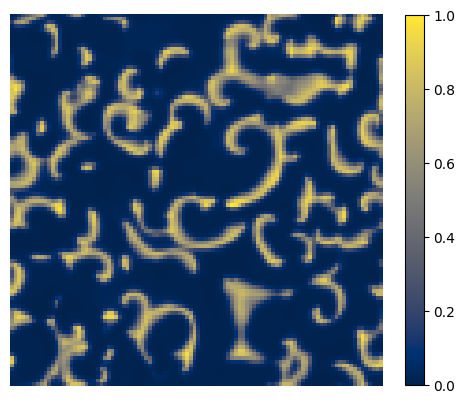

In [40]:
# simulate the PDE with finite difference method
for i in range(int(t/dt)):

    # update concentrations
    RT = RT + dt * (R(RT,RD,F) + Drt*periodic_laplacian(RT))
    RD = RD + dt * (k5 - k6*RD - R(RT,RD,F) + Drd*periodic_laplacian(RD))
    F = F + dt * (k7 + k8*RT**2 / (1 + k9*RT**2) - k10*dW*F + Df*periodic_laplacian(F))

    # update stocastic noise term every f seconds
    if i % int(f/dt) == 0:
        dW = correlated_gaussian_field()

    # capture a frame every frame_int seconds
    if i % int(frame_int/dt) == 0:
        frames.append([ax.imshow(RT, cmap='cividis', animated=True)])

# save animation
animation.ArtistAnimation(fig, frames, interval=50, blit=True).save('RT_animation.gif', writer=PillowWriter(fps=10))